In [2]:
from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import pandas as pd

import scipy.stats as stats
from scipy.stats import norm
import sklearn

In [3]:
## define path to input datasets (tidy format)
path_to_recog = '/home/jefan/neurosketch/neurosketch_voxelmat_freesurfer_recog'
path_to_draw = '/home/jefan/neurosketch/neurosketch_voxelmat_freesurfer_drawing'
roi_list = np.array(['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC'])

In [4]:
## get raw file list for recognition runs
RECOG_METAS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='csv'])
RECOG_FEATS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='npy'])
RECOG_SUBS = np.array([i.split('_')[0] for i in RECOG_FEATS])

recog_sub_list = np.unique(RECOG_SUBS)

def preprocess_recog(RECOG_METAS, RECOG_FEATS):
    M = [i for i in RECOG_METAS if len(i.split('.')[0].split('_'))==4]
    F = [i for i in RECOG_FEATS if len(i.split('.')[0].split('_'))==4]
    return M,F

RECOG_METAS, RECOG_FEATS = preprocess_recog(RECOG_METAS, RECOG_FEATS)

In [5]:
## get raw file list for drawing runs
DRAW_METAS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='csv'])
DRAW_FEATS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='npy'])
DRAW_SUBS = np.array([i.split('_')[0] for i in DRAW_FEATS])
draw_sub_list = np.unique(DRAW_SUBS)

In [6]:
## get subject ID's that have complete datasets from all phases of experiment
sub_list = np.intersect1d(recog_sub_list,draw_sub_list)
print 'Number of subs: {}'.format(len(sub_list))

Number of subs: 31


In [7]:
## filter file list so only contains the sessions that have full datasets
def extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS):
    _DRAW_METAS = [i for i in DRAW_METAS if i.split('_')[1] in sub_list]
    _DRAW_FEATS = [i for i in DRAW_FEATS if i.split('_')[0] in sub_list]
    _RECOG_METAS = [i for i in RECOG_METAS if i.split('_')[1] in sub_list]
    _RECOG_FEATS = [i for i in RECOG_FEATS if i.split('_')[0] in sub_list]
    return _DRAW_METAS, _DRAW_FEATS, _RECOG_METAS, _RECOG_FEATS

DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS =  \
extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS)

RECOG_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in RECOG_FEATS])
RECOG_ROIS = np.array([i.split('_')[1] for i in RECOG_FEATS])

DRAW_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in DRAW_FEATS])
DRAW_ROIS = np.array([i.split('_')[1] for i in DRAW_FEATS])

### How well do we do at classifying the target when we train on recognition patterns only?

In [8]:
#### Helper data loader functions
def load_draw_meta(this_sub):
    this_file = 'metadata_{}_drawing.csv'.format(this_sub)
    x = pd.read_csv(os.path.join(path_to_draw,this_file))
    x = x.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
    x['trial_num'] = np.repeat(np.arange(40),23)        
    return x
    
def load_draw_feats(this_sub,this_roi):
    this_file = '{}_{}_featurematrix.npy'.format(this_sub,this_roi)
    y = np.load(os.path.join(path_to_draw,this_file))
    y = y.transpose()
    return y

def load_draw_data(this_sub,this_roi):
    x = load_draw_meta(this_sub)
    y = load_draw_feats(this_sub,this_roi)
    assert y.shape[0] == x.shape[0]    
    return x,y

def load_recog_meta(this_sub,this_roi,this_phase):
    this_file = 'metadata_{}_{}_{}.csv'.format(this_sub,this_roi,this_phase)
    x = pd.read_csv(os.path.join(path_to_recog,this_file))
    x = x.drop(['Unnamed: 0'], axis=1)
    return x
    
def load_recog_feats(this_sub,this_roi,this_phase):
    this_file = '{}_{}_{}_featurematrix.npy'.format(this_sub,this_roi,this_phase)
    y = np.load(os.path.join(path_to_recog,this_file))
    y = y.transpose()
    return y    

def load_recog_data(this_sub,this_roi,this_phase):
    x = load_recog_meta(this_sub,this_roi,this_phase)
    y = load_recog_feats(this_sub,this_roi,this_phase)
    assert y.shape[0] == x.shape[0]    
    return x,y

# z-score normalization to de-mean & standardize variances within-voxel 
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

## plotting helper
def get_prob_timecourse(iv,DM):
    trained_objs = np.unique(DM.label.values)
    control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]
    t1 = trained_objs[0]
    t2 = trained_objs[1]
    c1 = control_objs[0]
    c2 = control_objs[1]
    target = np.vstack((DM[DM.label==t1].groupby(iv)['{}_prob'.format(t1)].mean().values,
                   DM[DM.label==t2].groupby(iv)['{}_prob'.format(t2)].mean().values)).mean(0) ## target timecourse
    foil = np.vstack((DM[DM.label==t1].groupby(iv)['{}_prob'.format(t2)].mean().values,
                   DM[DM.label==t2].groupby(iv)['{}_prob'.format(t1)].mean().values)).mean(0) ## foil timecourse
    control = np.vstack((DM[DM.label==t1].groupby(iv)['{}_prob'.format(c1)].mean().values,
                        DM[DM.label==t1].groupby(iv)['{}_prob'.format(c2)].mean().values,
                        DM[DM.label==t2].groupby(iv)['{}_prob'.format(c1)].mean().values,
                        DM[DM.label==t2].groupby(iv)['{}_prob'.format(c2)].mean().values)).mean(0) ## control timecourse
    
    return target, foil, control
     
def flatten(x):
    return [item for sublist in x for item in sublist]    

In [9]:
## general plotting params
sns.set_context('poster')
colors = sns.color_palette("cubehelix", 5)


In [10]:
## example subject, roi, and phase (localizer is default)
this_sub = sub_list[0]
this_roi = roi_list[2] ## order is: ['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC']
this_phase = '12' ## options are '12', '34', '56'

In [11]:
ALLDM = []

## loop through all subjects and rois
Acc = []
for this_roi in roi_list:
    print this_roi
    acc = []
    for this_sub in sub_list:
        ## load subject data in
        RM12, RF12 = load_recog_data(this_sub,this_roi,'12')
        RM34, RF34 = load_recog_data(this_sub,this_roi,'34')        
        RM = pd.concat([RM12,RM34])
        RF = np.vstack((RF12,RF34))        
        DM, DF = load_draw_data(this_sub,this_roi)
        assert RF.shape[1]==DF.shape[1] ## that number of voxels is identical

        # identify control objects; 
        # we wil train one classifier with 
        trained_objs = np.unique(DM.label.values)
        control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]
        probs = []        
        
        ## normalize voxels within task
        normalize_on = 1
        if normalize_on:
            _RF = normalize(RF)
            _DF = normalize(DF)
        else:
            _RF = RF
            _DF = DF

        # single train/test split
        X_train = _RF
        y_train = RM.label.values

        ## subset timepoints?
        inds = DM.time_point>0
        _DF = _DF[inds,:]
        DM = DM[DM.time_point>0]

        X_test = _DF
        y_test = DM.label.values
        clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)    

        ## add prediction probabilities to metadata matrix
        cats = clf.classes_
        probs = clf.predict_proba(X_test)
        DM['bed_prob'] = probs[:,0]
        DM['bench_prob'] = probs[:,1]
        DM['chair_prob'] = probs[:,2]
        DM['table_prob'] = probs[:,3]
        
        DM['subj'] = np.repeat(this_sub,DM.shape[0])
        DM['roi'] = np.repeat(this_roi,DM.shape[0])
        
        if len(ALLDM)==0:
            ALLDM = DM
        else:
            ALLDM = pd.concat([ALLDM,DM],ignore_index=True)

        ## plot probability timecourse
        fig = plt.figure(figsize=(5,5))
        iv = 'run_num'
        t,f,c = get_prob_timecourse(iv,DM)
        plt.plot(t,color=colors[0],label='target')
        plt.plot(f,color=colors[1],label='foil')
        plt.plot(c,color=colors[2],label='control')
        plt.legend(bbox_to_anchor=(1.45, 1.01))
        plt.ylim(0,1)
        plt.xlabel(iv)
        plt.ylabel('probability')
        if not os.path.exists('./plots/subj'):
            os.makedirs('./plots/subj')
        plt.tight_layout()
        plt.savefig('./plots/subj/{}_{}_prob_{}.pdf'.format(iv.split('_')[0],this_roi,this_sub))
        plt.close(fig)

        acc.append(clf.score(X_test, y_test))
    Acc.append(acc)

V1
V2
LOC
IT
fusiform
parahippo
PRC
ento
hipp
mOFC


In [40]:
def make_drawing_predictions(sub_list,roi_list,version='4way'):
    '''
    input:
        sub_list: a list containing subject IDs
        roi_list: a list containing roi names
        version: a string from options: ['4way','3way','2way']
            4way: trains to discriminate all four objects from recognition runs
            3way: subsamples one of the control objects, trains 3-way classifier
                    that outputs probabilities for target, foil, and control objects
                    that is then aggregated across classifiers
            2way: trains to discriminate only the two trained objects from recognition runs
                    then makes predictions on drawing data
    '''

    ALLDM = []
    ## loop through all subjects and rois
    Acc = []
    for this_roi in roi_list:
        print(this_roi)
        acc = []
        for this_sub in sub_list:
            print(this_sub)
            ## load subject data in
            RM12, RF12 = load_recog_data(this_sub,this_roi,'12')
            RM34, RF34 = load_recog_data(this_sub,this_roi,'34')
            RM = pd.concat([RM12,RM34])
            RF = np.vstack((RF12,RF34))
            DM, DF = load_draw_data(this_sub,this_roi)
            assert RF.shape[1]==DF.shape[1] ## that number of voxels is identical

            # identify control objects;
            # we wil train one classifier with
            trained_objs = np.unique(DM.label.values)
            control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]
            probs = []
            logprobs = []

            if version=='4way':
                ## normalize voxels within task
                normalize_on = 1
                if normalize_on:
                    _RF = normalize(RF)
                    _DF = normalize(DF)
                else:
                    _RF = RF
                    _DF = DF

                # single train/test split
                X_train = _RF
                y_train = RM.label.values

                X_test = _DF
                y_test = DM.label.values
                clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)

                ## add prediction probabilities to metadata matrix
                cats = clf.classes_
                probs = clf.predict_proba(X_test)

                ## add prediction probabilities to metadata matrix
                ## must sort so that trained are first, and control is last
                cats = list(clf.classes_)
                t1_index = cats.index(trained_objs[0]) ## this is not always the target
                t2_index = cats.index(trained_objs[1]) ## this is not always the target
                c1_index = cats.index(control_objs[0])
                c2_index = cats.index(control_objs[1])
                ordering = np.argsort([t1_index, t2_index, c1_index, c2_index])
                probs = clf.predict_proba(X_test)[:,ordering]
                logprobs = np.log(clf.predict_proba(X_test)[:,ordering])

                DM['t1_prob'] = logprobs[:,0]
                DM['t2_prob'] = logprobs[:,1]
                DM['c1_prob'] = logprobs[:,2]
                DM['c2_prob'] = logprobs[:,3]

            elif version=='3way':

                for ctrl in control_objs:

                    inds = RM.label != ctrl
                    _RM = RM[inds]

                    ## normalize voxels within task
                    normalize_on = 1
                    if normalize_on:
                        _RF = normalize(RF[inds,:])
                        _DF = normalize(DF)
                    else:
                        _RF = RF[inds,:]
                        _DF = DF

                    # single train/test split
                    X_train = _RF # recognition run feature set
                    y_train = _RM.label.values # list of labels for the training set

                    X_test = _DF
                    y_test = DM.label.values
                    clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)

                    ## add prediction probabilities to metadata matrix
                    ## must sort so that trained are first, and control is last
                    cats = list(clf.classes_)
                    ctrl_index = cats.index([c for c in control_objs if c != ctrl][0])
                    t1_index = cats.index(trained_objs[0]) ## this is not always the target
                    t2_index = cats.index(trained_objs[1]) ## this is not always the target
                    ordering = np.argsort([t1_index, t2_index, ctrl_index])
                    probs.append(clf.predict_proba(X_test)[:,ordering])
                    logprobs.append(np.log(clf.predict_proba(X_test)[:,ordering]))

                DM['t1_prob'] = (logprobs[0][:,0] + logprobs[1][:,0])/2.0
                DM['t2_prob'] = (logprobs[0][:,1] + logprobs[1][:,1])/2.0
                DM['c_prob'] = (logprobs[0][:,2] + logprobs[1][:,2])/2.0

            elif version=='2way':

                ## subset recognition data matrices to only include the trained classes
                inds = RM.label.isin(control_objs)
                _RM = RM[inds]

                ## normalize voxels within task
                normalize_on = 1
                if normalize_on:
                    _RF = normalize(RF[inds,:])
                    _DF = normalize(DF)
                else:
                    _RF = RF[inds,:]
                    _DF = DF

                # single train/test split
                X_train = _RF # recognition run feature set
                y_train = _RM.label.values # list of labels for the training set

                X_test = _DF
                y_test = DM.label.values
                clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)

                probs = clf.predict_proba(X_test)

                ## add prediction probabilities to metadata matrix
                ## must sort so that trained are first, and control is last
                cats = list(clf.classes_)
                t1_index = cats.index(trained_objs[0]) ## this is not always the target
                t2_index = cats.index(trained_objs[1]) ## this is not always the target
                ordering = np.argsort([t1_index, t2_index])

                probs = clf.predict_proba(X_test)[:,ordering]
                logprobs = np.log(clf.predict_proba(X_test)[:,ordering])

                DM['t1_prob'] = logprobs[:,0]
                DM['t2_prob'] = logprobs[:,1]

            DM['subj'] = np.repeat(this_sub,DM.shape[0])
            DM['roi'] = np.repeat(this_roi,DM.shape[0])

            if len(ALLDM)==0:
                ALLDM = DM
            else:
                ALLDM = pd.concat([ALLDM,DM],ignore_index=True)

            acc.append(clf.score(X_test, y_test))

        Acc.append(acc)

    return ALLDM, Acc


In [ ]:
import analysis_helpers
reload(analysis_helpers)
roi_list_short = roi_list[:3]
sub_list_short = sub_list
ALLDM, Acc = analysis_helpers.make_drawing_predictions(sub_list_short,roi_list_short,version='4way')

V1
0110171
0110172
0111171
0112171
0112172
0112173
0113171
0115174
0117171
0118171
0118172
0119171
0119172
0119173
0119174
0120171
0120172
0120173
0123171
0123173
0124171
0125171
0125172
1121161
1130161
1202161
1203161
1206161
1206162
1206163
1207162
V2
0110171
0110172


In [46]:
ALLDM.head()

,subj,label,run_num,TR_num,time_point,trial_num,t1_prob,t2_prob,c1_prob,c2_prob,roi
0,0110171,bed,1,10,1,0,-0.240904,-4.285727,-4.559778,-1.661495,V1
1,0110171,bed,1,11,2,0,-0.058214,-4.372853,-4.365698,-3.466339,V1
2,0110171,bed,1,12,3,0,-1.497156,-2.135614,-3.877081,-0.450434,V1
3,0110171,bed,1,13,4,0,-3.994046,-0.845558,-10.338768,-0.593800,V1
4,0110171,bed,1,14,5,0,-0.918023,-7.160209,-2.914799,-0.605685,V1


In [50]:
Acc

array([[ 0.2673913 ,  0.23586957,  0.22608696,  0.31413043,  0.20978261],
       [ 0.25978261,  0.20217391,  0.23478261,  0.29891304,  0.29891304],
       [ 0.2826087 ,  0.28369565,  0.2326087 ,  0.20217391,  0.29456522]])

In [51]:
Acc = np.array(Acc)
x = pd.DataFrame(Acc.transpose())
x.columns = roi_list_short

(0, 0.35)

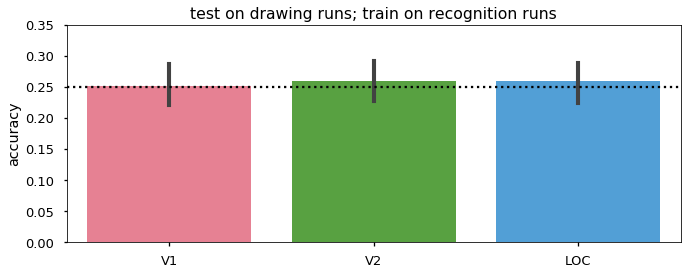

In [52]:
sns.set_context('talk')
plt.figure(figsize=(11,4))
sns.barplot(data=x,palette='husl',ci=95)
plt.axhline(0.25,linestyle=':',color='k')
plt.ylabel('accuracy')
plt.title('test on drawing runs; train on recognition runs')
plt.ylim(0,0.35)

In [15]:
ALLDM.to_csv('./logistic_timeseries_neural_vgg.csv') ## train recog, test drawing run

In [16]:
ALLDM.head()

,TR_num,bed_prob,bench_prob,chair_prob,label,roi,run_num,subj,table_prob,time_point,trial_num
0,10,0.785917,0.013764,0.010464,bed,V1,1,0110171,0.189855,1,0
1,11,0.943448,0.012615,0.012706,bed,V1,1,0110171,0.031231,2,0
2,12,0.223766,0.118172,0.020711,bed,V1,1,0110171,0.637351,3,0
3,13,0.018425,0.429318,0.000032,bed,V1,1,0110171,0.552225,4,0
4,14,0.399308,0.000777,0.054215,bed,V1,1,0110171,0.545701,5,0


In [19]:
sns.set_context('paper')
this_roi = 'V1'
subs = np.unique(ALLDM.subj.values)
lookup = dict(zip(['trial_num','run_num','time_point'],['repetition','run','TR']))
ivs = ['run_num','trial_num','time_point']
this_iv = 'time_point'

## do you want to render the CONDITION-wise plots -- trained vs. foil vs control
## or the DIFFERENCE plots -- trained - foil vs foil - control?
render_cond = 1

for this_iv in ivs:
    for this_roi in roi_list:

        T = []
        F = []
        C = []
        Sub = []
        for sub in subs:
            inds =(ALLDM['roi']==this_roi) & (ALLDM['subj']==sub) 
            t,f,c = get_prob_timecourse(this_iv,ALLDM[inds])
            if len(T)==0:
                T = t
                F = f
                C = c
                DTF = t-f                
                DTC = t-c
                DFC = f-c
            else:
                T = np.hstack((T,t))
                F = np.hstack((F,f))        
                C = np.hstack((C,c)) 
                DTF = np.hstack((DTF,np.log(t)-np.log(f)))                
                DTC = np.hstack((DTC,np.log(t)-np.log(c)))
                DFC = np.hstack((DFC,np.log(f)-np.log(c)))
            Sub.append([sub]*len(t))   
          
        if render_cond==1:
            ## make longform version of dataframe to use in tsplot (by condition)            
            Trial = np.tile(np.arange(len(t)),len(subs)*3)
            Condition = np.repeat(['target','foil','control'],len(T))
            Sub = np.tile(np.array(flatten(Sub)),3)
            Prob = np.hstack((T,F,C))
            assert len(Trial)==len(Condition)
            assert len(Sub)==len(Prob)
            assert len(Condition)==len(Sub)
            x = pd.DataFrame([Prob,Trial,Condition,Sub])
            x = x.transpose()
            x.columns = ['probability',lookup[this_iv],'condition','sub']
            toop = 'condition'            
        else:
            ## make longform version of dataframe to use in tsplot (difference btw conditions)                    
            Trial = np.tile(np.arange(len(t)),len(subs)*3)
            Condition = np.repeat(['target-foil','target-control','foil-control'],len(T))
            Sub = np.tile(np.array(flatten(Sub)),3)
            Prob = np.hstack((DTF,DTC,DFC))        
            assert len(Trial)==len(Condition)
            assert len(Sub)==len(Prob)
            assert len(Condition)==len(Sub)
            x = pd.DataFrame([Prob,Trial,Condition,Sub])
            x = x.transpose()
            x.columns = ['probability',lookup[this_iv],'condition','sub']        
            toop = 'difference'
        fig = plt.figure(figsize=(8,4))
        ## plot it
        sns.tsplot(data=x,
                  time=lookup[this_iv],
                  unit='sub',
                  condition='condition',
                  value='probability',
                  ci=95)
        if render_cond==1:
            plt.ylim(0,0.5)
            plt.axhline(0.25,linestyle=':',color='k')  
            plt.legend(bbox_to_anchor=(0.8, 1.01))  
            plt.title('Classifier evidence by condition in {}'.format(this_roi))
            
        else:
            plt.ylim(-0.3,0.3)
            plt.axhline(0,linestyle=':',color='k')  
            plt.legend(bbox_to_anchor=(0.7, 1.01))                        
            plt.title('Difference in classifier evidence by condition in {}'.format(this_roi))        
        plt.xticks(np.arange(np.max(x[lookup[this_iv]].values)+1))
        if not os.path.exists('./plots/roi/{}/{}'.format(lookup[this_iv],toop)):
            os.makedirs('./plots/roi/{}/{}'.format(lookup[this_iv],toop))
        plt.tight_layout()        
        plt.savefig('./plots/roi/{}/{}/prob_timecourse_{}_by_{}.pdf'.\
                    format(lookup[this_iv],toop,this_roi,lookup[this_iv]))
        plt.close(fig)

In [27]:
## get subject-level index of contrast between objects during drawing
sub_tf = []
sub_tc = []
sub_fc = []
roi = []

subs = np.unique(ALLDM.subj.values)
ivs = ['time_point'] ## other options 'run_num','trial_num',

## do you want to render the CONDITION-wise plots -- trained vs. foil vs control
## or the DIFFERENCE plots -- trained - foil vs foil - control?
render_cond = 0

for this_iv in ivs:
    for this_roi in roi_list:

        T = []
        F = []
        C = []
        Sub = []
        for sub in subs:
            inds =(ALLDM['roi']==this_roi) & (ALLDM['subj']==sub) 
            t,f,c = get_prob_timecourse(this_iv,ALLDM[inds])
            if len(T)==0:
                T = t
                F = f
                C = c
                DTF = np.log(t)-np.log(f)               
                DTC = np.log(t)-np.log(c)
                DFC = np.log(f)-np.log(c)
            else:
                T = np.hstack((T,t))
                F = np.hstack((F,f))        
                C = np.hstack((C,c)) 
                DTF = np.hstack((DTF,np.log(t)-np.log(f)))                
                DTC = np.hstack((DTC,np.log(t)-np.log(c)))
                DFC = np.hstack((DFC,np.log(f)-np.log(c)))
            Sub.append([sub]*len(t))   
          
        ## make longform version of dataframe to use in tsplot (difference btw conditions)                    
        Trial = np.tile(np.arange(len(t)),len(subs)*3)
        Condition = np.repeat(['target-foil','target-control','foil-control'],len(T))
        Sub = np.tile(np.array(flatten(Sub)),3)
        Prob = np.hstack((DTF,DTC,DFC))        
        assert len(Trial)==len(Condition)
        assert len(Sub)==len(Prob)
        assert len(Condition)==len(Sub)
        x = pd.DataFrame([Prob,Trial,Condition,Sub])
        x = x.transpose()
        x.columns = ['probability',lookup[this_iv],'condition','sub']
        
        for this_sub in subs:
            sub_tf.append(x[(x['condition']=='target-foil') & (x['sub']==this_sub)]['probability'].mean())
            sub_tc.append(x[(x['condition']=='target-control') & (x['sub']==this_sub)]['probability'].mean())  
            sub_fc.append(x[(x['condition']=='foil-control') & (x['sub']==this_sub)]['probability'].mean()) 
            roi.append(this_roi)
            
## make dataframe with subject-level difference scores
d = pd.DataFrame([sub_tf,sub_tc,sub_fc,roi])
d = d.transpose()
d.columns = ['target-foil','target-control','foil-control','roi']

713

In [29]:
for this_roi in roi_list:
    data = d[d['roi']==this_roi]['target-foil']
    t,p = stats.ttest_1samp(data,0)
    print 'ROI = {} | t = {}, p = {}'.format(this_roi,t,p)

ROI = V1 | t = 5.9698210614, p = 1.51704229826e-06
ROI = V2 | t = 7.03784023208, p = 8.00684200351e-08
ROI = LOC | t = 5.45565640293, p = 6.43493874254e-06
ROI = IT | t = 0.123691583917, p = 0.902384495233
ROI = fusiform | t = 3.07071470724, p = 0.00450798152163
ROI = parahippo | t = 0.432171534113, p = 0.66870734284
ROI = PRC | t = -0.588518217441, p = 0.560589711167
ROI = ento | t = -1.10212831966, p = 0.279169580372
ROI = hipp | t = -1.17681201247, p = 0.248523689627
ROI = mOFC | t = -1.15460804914, p = 0.257365617307


In [30]:
for this_roi in roi_list:
    data = d[d['roi']==this_roi]['target-control']
    t,p = stats.ttest_1samp(data,0)
    print 'ROI = {} | t = {}, p = {}'.format(this_roi,t,p)

ROI = V1 | t = 3.5747352938, p = 0.00121025277137
ROI = V2 | t = 4.65037421355, p = 6.24144832754e-05
ROI = LOC | t = 2.53558696476, p = 0.0166726989644
ROI = IT | t = -0.704940453184, p = 0.486284716378
ROI = fusiform | t = 0.390957955127, p = 0.698591117365
ROI = parahippo | t = -1.05214076966, p = 0.301136312844
ROI = PRC | t = -1.96471877298, p = 0.0587679295666
ROI = ento | t = -1.91602397118, p = 0.0649345374666
ROI = hipp | t = -1.3905630156, p = 0.17458830511
ROI = mOFC | t = -0.112142971835, p = 0.911457052277


In [31]:
for this_roi in roi_list:
    data = d[d['roi']==this_roi]['foil-control']
    t,p = stats.ttest_1samp(data,0)
    print 'ROI = {} | t = {}, p = {}'.format(this_roi,t,p)

ROI = V1 | t = -5.9769458172, p = 1.48711066502e-06
ROI = V2 | t = -7.42973361161, p = 2.79935926404e-08
ROI = LOC | t = -3.85582431085, p = 0.000566610731334
ROI = IT | t = -0.955485662488, p = 0.346968732005
ROI = fusiform | t = -2.84258739067, p = 0.00797481909361
ROI = parahippo | t = -1.39362499916, p = 0.173670077966
ROI = PRC | t = -0.982302681787, p = 0.333806866067
ROI = ento | t = -0.6557858319, p = 0.516960118161
ROI = hipp | t = -0.521954747238, p = 0.605534655981
ROI = mOFC | t = 0.642039357636, p = 0.525723708744


### read in pre-post changes

In [32]:
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')

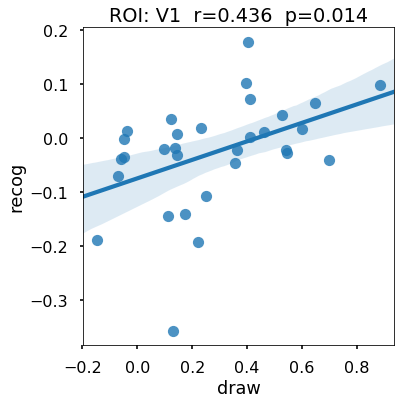

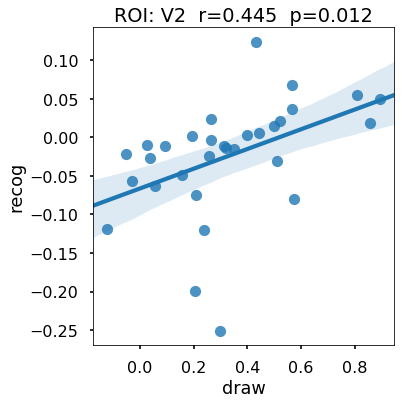

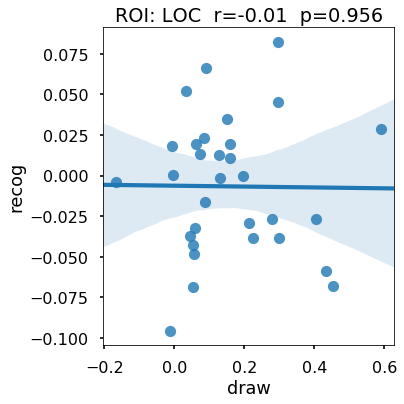

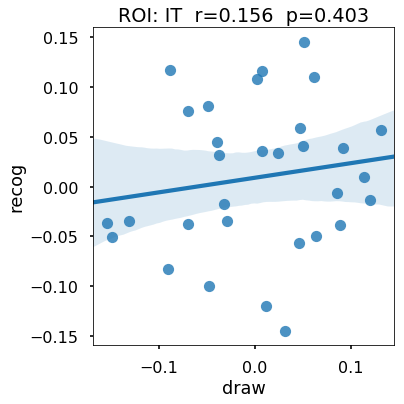

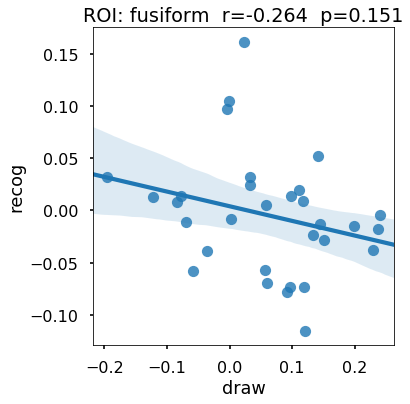

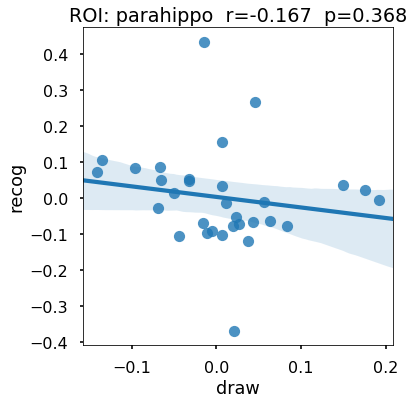

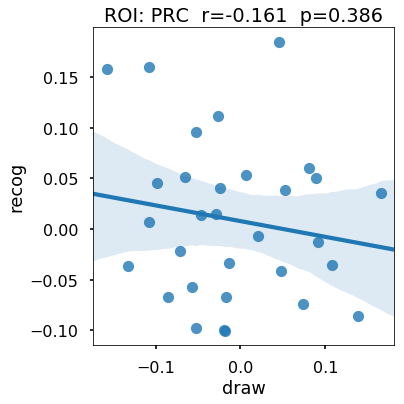

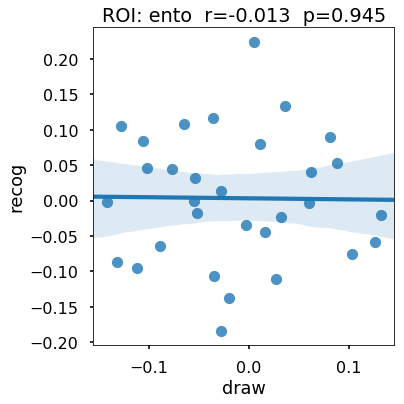

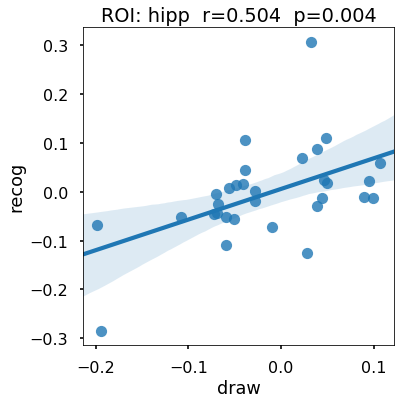

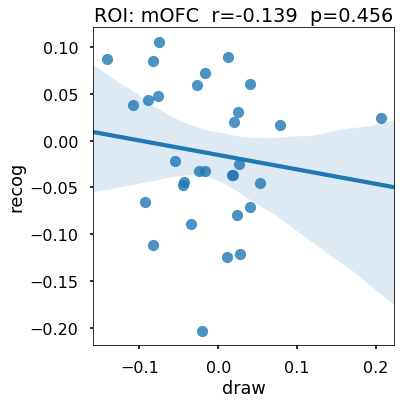

In [37]:
## make dataframe to relate drawing contrast to recognition differentiation
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp', 'mOFC']
this_roi = 'hipp'

for this_roi in roi_list:
#     draw = d[d['roi']==this_roi]['target-control'].values - d[d['roi']==this_roi]['foil-control'].values
    draw = d[d['roi']==this_roi]['target-foil'].values
    recog = prepost['tradiff_{}'.format(this_roi)].values-prepost['condiff_{}'.format(this_roi)].values
#     recog = prepost['tradiff_{}'.format(this_roi)].values

    z = pd.DataFrame([draw,recog])
    z = z.transpose()
    z.columns=['draw','recog']

    ## plot 
    fig = plt.figure(figsize=(6,6))
    sns.set_context('poster')
    sns.regplot(x="draw",
                y ="recog",
                data=z)
    r,p = stats.pearsonr(draw,recog)
    plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,3),np.round(p,3)))
    if not os.path.exists('./plots/roi/drawrecog'):
        os.makedirs('./plots/roi/drawrecog')
    plt.tight_layout()
#     plt.savefig('./plots/roi/drawrecog/draw_recog_scatter_{}.pdf'.format(this_roi))
#     plt.close(fig)        

### relate neural to vgg drawing time series

In [ ]:
vgg_ts = pd.read_csv('./logistic_timeseries_drawing_vgg.csv')
neural_ts = pd.read_csv('./logistic_timeseries_drawing_neural.csv')

In [793]:
vgg_ts = vgg_ts.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
vgg_ts.wID = [i.split('_')[0] for i in vgg_ts.wID.values]

In [794]:
vgg_ts.head()

,index,wID,viewpoint,trial,trialDuration,target,competitor,numSketch,bed,bench,chair,table,curr_winner,tc_pair,trialID,run,target_val,competitor_val,control_val
0,0,0119174,20,320,39.00144,bench,chair,0,0.026822,0.055895,0.916243,0.001040,chair,bench/chair,0119174_neurosketch_320,1.0,0.055895,0.916243,0.013931
1,0,0119174,20,320,39.00144,bench,chair,1,0.934225,0.026225,0.039085,0.000465,bed,bench/chair,0119174_neurosketch_320,1.0,0.026225,0.039085,0.467345
2,0,0119174,20,320,39.00144,bench,chair,2,0.006035,0.970770,0.002714,0.020481,bench,bench/chair,0119174_neurosketch_320,1.0,0.970770,0.002714,0.013258
3,0,0119174,20,320,39.00144,bench,chair,3,0.009842,0.978927,0.003784,0.007447,bench,bench/chair,0119174_neurosketch_320,1.0,0.978927,0.003784,0.008644
4,0,0119174,20,320,39.00144,bench,chair,4,0.019298,0.967674,0.001463,0.011564,bench,bench/chair,0119174_neurosketch_320,1.0,0.967674,0.001463,0.015431


In [839]:
## plotting helper
def get_vgg_timecourse(iv,w):
    trained_objs = np.unique(w.target.values)
    control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]
    t1 = trained_objs[0]
    t2 = trained_objs[1]
    c1 = control_objs[0]
    c2 = control_objs[1]
    target = np.vstack((w[w.target==t1].groupby(iv)['{}'.format(t1)].mean().values,
                   w[w.target==t2].groupby(iv)['{}'.format(t2)].mean().values)).mean(0) ## target timecourse
    foil = np.vstack((w[w.target==t1].groupby(iv)['{}'.format(t2)].mean().values,
                   w[w.target==t2].groupby(iv)['{}'.format(t1)].mean().values)).mean(0) ## foil timecourse
    control = np.vstack((w[w.target==t1].groupby(iv)['{}'.format(c1)].mean().values,
                        w[w.target==t1].groupby(iv)['{}'.format(c2)].mean().values,
                        w[w.target==t2].groupby(iv)['{}'.format(c1)].mean().values,
                        w[w.target==t2].groupby(iv)['{}'.format(c2)].mean().values)).mean(0) ## control timecourse

    return target, foil, control

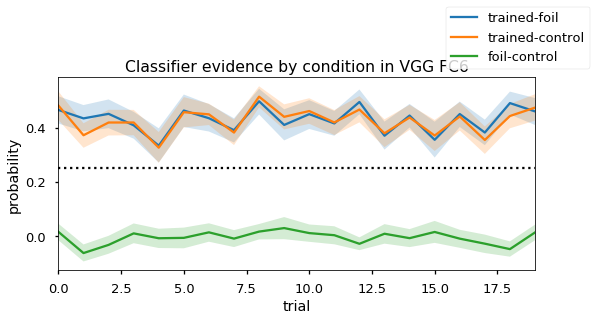

In [876]:
render_cond = 0

## get subject-level index of contrast between objects during drawing
sub_tf = []
sub_tc = []
sub_fc = []
roi = []

T = []
F = []
C = []
Sub = []

this_iv = 'trial' ## options: 'trial' and 'numSketch'
for this_sub in subs:
    inds = (vgg_ts['wID']==this_sub)
    w = vgg_ts[inds]
    t,f,c = get_vgg_timecourse(this_iv,w)
    
    if len(T)==0:
        T = t
        F = f
        C = c
        DTF = t-f                
        DTC = t-c
        DFC = f-c
    else:
        T = np.hstack((T,t))
        F = np.hstack((F,f))        
        C = np.hstack((C,c)) 
        DTF = np.hstack((DTF,t-f))                
        DTC = np.hstack((DTC,t-c))
        DFC = np.hstack((DFC,f-c))
    Sub.append([this_sub]*len(t))   

if render_cond==1:
    ## make longform version of dataframe to use in tsplot (by condition)            
    Trial = np.tile(np.arange(len(t)),len(subs)*3)
    Condition = np.repeat(['trained','foil','control'],len(T))
    Sub = np.tile(np.array(flatten(Sub)),3)
    Prob = np.hstack((T,F,C))
    assert len(Trial)==len(Condition)
    assert len(Sub)==len(Prob)
    assert len(Condition)==len(Sub)
    x = pd.DataFrame([Prob,Trial,Condition,Sub])
    x = x.transpose()
    x.columns = ['probability',this_iv,'condition','sub']
else:
    ## make longform version of dataframe to use in tsplot (difference btw conditions)                    
    Trial = np.tile(np.arange(len(t)),len(subs)*3)
    Condition = np.repeat(['trained-foil','trained-control','foil-control'],len(T))
    Sub = np.tile(np.array(flatten(Sub)),3)
    Prob = np.hstack((DTF,DTC,DFC))        
    assert len(Trial)==len(Condition)
    assert len(Sub)==len(Prob)
    assert len(Condition)==len(Sub)
    x = pd.DataFrame([Prob,Trial,Condition,Sub])
    x = x.transpose()
    x.columns = ['probability',this_iv,'condition','sub']
    
    for this_sub in subs:
        sub_tf.append(x[(x['condition']=='trained-foil') & (x['sub']==this_sub)]['probability'].mean())
        sub_tc.append(x[(x['condition']=='trained-control') & (x['sub']==this_sub)]['probability'].mean())  
        sub_fc.append(x[(x['condition']=='foil-control') & (x['sub']==this_sub)]['probability'].mean()) 
        roi.append('vgg_fc6')
        
    ## make dataframe with subject-level difference scores
    d2 = pd.DataFrame([sub_tf,sub_tc,sub_fc,roi])
    d2 = d2.transpose()
    d2.columns = ['trained-foil','trained-control','foil-control','roi']        

## plot it
fig = plt.figure(figsize=(8,4))
## plot it
sns.tsplot(data=x,
          time=this_iv,
          unit='sub',
          condition='condition',
          value='probability')
# plt.ylim(0,0.5)
plt.axhline(0.25,linestyle=':',color='k')  
plt.legend(bbox_to_anchor=(0.8, 1.01))  
plt.title('Classifier evidence by condition in VGG FC6')
plt.tight_layout()  

In [882]:
## make dataframe to relate drawing contrast to recognition differentiation
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp', 'mOFC']

for this_roi in roi_list:
    neural = d[d['roi']==this_roi]['trained-control'].values - d[d['roi']==this_roi]['foil-control'].values
    vgg = d2['trained-foil'].values

    z = pd.DataFrame([neural,vgg])
    z = z.transpose()
    z.columns=['neural','vgg']

    ## plot 
    fig = plt.figure(figsize=(6,6))
    sns.set_context('poster')
    sns.regplot(x="neural",
                y ="vgg",
                data=z)
    r,p = stats.pearsonr(neural,vgg)
    plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,3),np.round(p,3)))
    if not os.path.exists('./plots/roi/neuralvgg'):
        os.makedirs('./plots/roi/neuralvgg')
    plt.tight_layout()
    plt.savefig('./plots/roi/neuralvgg/neural_vgg_scatter_{}.pdf'.format(this_roi))
    plt.close(fig)    
    

### compare 4-way, 3-way, and 2-way way of getting target-foil contrasts

In [887]:
x = pd.read_csv('log_probs_nway_roi.csv')
x = x.drop(['Unnamed: 0'], axis=1)

In [893]:
x.groupby('roi').apply(lambda x: np.exp(np.mean(x)))

,2way,3way,4way
roi,,,
LOC,1.516493,1.182913,1.063207
PRC,0.996875,0.987663,1.013996
V1,1.920052,1.143023,0.804087
V2,2.055028,1.179451,0.805025


In [894]:
x.groupby('roi').apply(lambda x: np.mean(x))

,2way,3way,4way
roi,,,
LOC,0.416400,0.167980,0.061290
PRC,-0.003129,-0.012413,0.013899
V1,0.652352,0.133676,-0.218047
V2,0.720289,0.165049,-0.216882
